In [228]:
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import minimize

# Реализация дерева

In [206]:
class TreeNode(object):
    def __init__(self, j, t):
        self.j = j
        self.t = t
        self.left_node = None
        self.right_node = None
        self.result = None
    
    #X => L, R
    def divide_set(self, X):
        left_mask = X[:, self.j] <= self.t
        right_mask = np.array([True] * len(X)) ^ left_mask
        L = X[left_mask]
        R = X[right_mask]
        return L, R
    
    def divide_set_values(self, Q, y, j=None, t=None):
        if j is None:
            j = self.j
        if t is None:
            t = self.t
        left_mask = Q[:, j] <= t
        right_mask = np.array([True] * len(Q)) ^ left_mask
        L_y = y[left_mask]
        R_y = y[right_mask]
        return L_y, R_y
    #Q => L, R
    def get_score(self, H, Q, y, j=None, t=None):
        if j is None:
            j = self.j
        if t is None:
            t = self.t
        L_y, R_y = self.divide_set_values(Q, y, j, t)
        return float(len(L_y) * H(L_y) + len(R_y) * H(R_y))/len(Q)
         

In [207]:
def MSE_of_set(y):
    if len(y) == 0:
        return 0
    return mean_squared_error(y, np.array([np.mean(y)] * len(y)))

In [208]:
def entropy_of_set(y):
    p = [float(np.sum(y==val))/len(y) for val in np.unique(y)]
    return np.sum([-1*p_i*np.log(p_i) for p_i in p])

In [209]:
def gini_of_set(y):
    p = [float(np.sum(y==val))/len(y) for val in np.unique(y)]
    return np.sum([p_i*(1-p_i) for p_i in p])

In [238]:
def misclassification_of_set(y):
    if len(y) == 0:
        return 0
    p = [float(np.sum(y==val))/len(y) for val in np.unique(y)]
    return 1 - np.max(p)

In [211]:
from exceptions import ValueError

In [212]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=30, criterion='gini/MSE'):
        self.max_depth = max_depth
        self.criterion = criterion
        self.root = None
        if self.criterion == 'gini/MSE':
            self.estimator_type = None
        elif self.criterion in ['gini', 'entropy', 'misclassification']:
            self.estimator_type = 'classifier'
        elif self.criterion in ['MSE']:
            self.estimator_type = 'regressor'
        else:
            raise ValueError('Invalid criterion argument')   #Exception
        
    def fit(self, X, y):
        if self.estimator_type == None:
            if y.dtype in ['float64', 'float32', 'float']:
                self.criterion = 'MSE'
                self.estimator_type = 'regressor'
            else:
                self.criterion = 'gini'
                self.estimator_type = 'classifier'
        self.root = TreeNode(0, 0)
        nodes = [(self.root, X, y, 1)]
        while len(nodes) > 0:
            node, Q, y_Q, depth = nodes[0]
            nodes = nodes[1:]
            j, t = self.get_node_optimal_parameters(Q, y_Q, node)
            node.j = j
            node.t = t
            if self.estimator_type == 'regressor':
                node.result = np.mean(y_Q)
            else:
                node.result = np.unique(y_Q)[np.argmax([np.sum(y_Q==val) \
                                                      for val in np.unique(y_Q)])]
            if depth < self.max_depth:
                L, R = node.divide_set(Q)
                L_y, R_y = node.divide_set_values(Q, y_Q)
                if(len(L_y) != 0 and len(R_y) != 0):
                    node.left_node = TreeNode(0, 0)
                    node.right_node = TreeNode(0, 0)
                    nodes.append((node.left_node, L, L_y, depth+1))
                    nodes.append((node.right_node, R, R_y, depth+1))
        return self
        
    def predict(self, X):
        y_predict = []
        for i in range(len(X)):
            node = self.root
            Q = X[i]
            while node.left_node is not None:
                if Q[node.j] <= node.t:
                    node = node.left_node
                else:
                    node = node.right_node
            y_predict.append(node.result)
        return y_predict
        
        
    def get_criterion(self):
        if self.criterion == 'MSE':
            return MSE_of_set
        elif self.criterion == 'gini':
            return gini_of_set
        elif self.criterion == 'entropy':
            return entropy_of_set
        elif self.criterion == 'misclassification':
            return misclassification_of_set
        else:
            raise AttributeError('Invalid criterion') #Exception
        
    def get_node_optimal_parameters(self, X, y, node):
        scores = []
        for i in range(np.shape(X)[1]):
            if np.dtype(X[0, i]) in ['float', 'float32', 'float64'] :
                minimized = minimize(
                    lambda x: node.get_score(self.get_criterion(), X, y, i, x), 
                            X[0,i])
                scores.append([minimized.x[0], minimized.fun])
            else:
                t_scores = np.array(
                    [[val, node.get_score(self.get_criterion(), X, y, i, val)] \
                     for val in np.unique(X[:, i])])
                scores.append(t_scores[np.argmin(t_scores[:, 1])])
        scores = np.array(scores)
        j = np.argmin(scores[:, 1])
        #print('{} {}'.format(j, scores))
        t = scores[j, 0]
        return j, t

## Некоторые тесты

In [213]:
def test_node(X, y):
    node = TreeNode(np.shape(X)[1]/2, np.mean(X[:, np.shape(X)[1]/2]))
    L, R = node.divide_set(X)
    print((np.shape(L), np.shape(R)))
    print(node.get_score(MSE_of_set, X, y))

In [235]:
from sklearn.datasets import load_boston

boston = load_boston()
X = boston.data
y = boston.target

In [215]:
test_node(X, y)

((213, 13), (293, 13))
74.5402393556


In [216]:
X_train = X[:3*len(X)/4]
X_test = X[3*len(X)/4:]
y_train = y[:3*len(X)/4]
y_test = y[3*len(X)/4:]

In [217]:
def DepthPlot(acc_score, sk_score, title):
    plt.title(title)
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    line0, = plt.plot(range(2, 15), acc_score)
    line1, = plt.plot(range(2, 15), sk_score)
    plt.legend([line0, line1], ['tree', 'sklearn'])
    plt.show()

In [236]:
estimator = DecisionTree(criterion='MSE')
est = estimator.fit(X_train, y_train)
print(mean_squared_error(y_test, est.predict(X_test)))
estimator = DecisionTreeRegressor()
est = estimator.fit(X_train, y_train)
print(mean_squared_error(y_test, est.predict(X_test)))

0.348
0.308


In [187]:
t0 = time()
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

acc_score = []
sk_score = []
for depth in range(2, 15):
    tree = DecisionTree(max_depth=depth)
    tree.fit(X, y)
    sk_tree = DecisionTreeRegressor(max_depth=depth)
    sk_tree.fit(X, y)
    acc_score.append(cross_val_score(tree, X, y, scoring='neg_mean_squared_error').mean())
    sk_score.append(cross_val_score(sk_tree, X, y, scoring='neg_mean_squared_error').mean())
print(time() - t0)

113.781146049


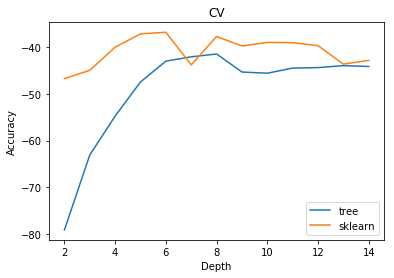

In [190]:
DepthPlot(acc_score, sk_score, 'CV')

In [191]:
t0=time()
acc_score = []
sk_score = []
for depth in range(2, 15):
    tree = DecisionTree(max_depth=depth)
    tree.fit(X, y)
    sk_tree = DecisionTreeRegressor(max_depth=depth)
    sk_tree.fit(X, y)
    acc_score.append(mean_squared_error(y, tree.predict(X)))
    sk_score.append(mean_squared_error(y, sk_tree.predict(X)))
print(time() - t0)

35.057101965


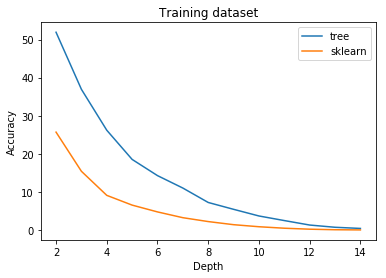

In [192]:
DepthPlot(acc_score, sk_score, 'Training dataset')

In [234]:
import pandas as pd
data = pd.read_csv('german.data-numeric', header=None, delim_whitespace=True)

X = data[list(set(data.columns) - set([24]))].values
y = data[24].values
X_train = X[:3*len(X)/4]
X_test = X[3*len(X)/4:]
y_train = y[:3*len(X)/4]
y_test = y[3*len(X)/4:]

In [239]:
estimator = DecisionTree(criterion='gini', max_depth=5)
est = estimator.fit(X_train, y_train)
print(accuracy_score(y_test, est.predict(X_test)))
estimator = DecisionTreeClassifier(max_depth=5)
est = estimator.fit(X_train, y_train)
print(accuracy_score(y_test, est.predict(X_test)))
estimator = DecisionTree(criterion='entropy', max_depth=5)
est = estimator.fit(X_train, y_train)
print(accuracy_score(y_test, est.predict(X_test)))
estimator = DecisionTreeClassifier(max_depth=5)
est = estimator.fit(X_train, y_train)
print(accuracy_score(y_test, est.predict(X_test)))
estimator = DecisionTree(criterion='misclassification', max_depth=5)
est = estimator.fit(X_train, y_train)
print(accuracy_score(y_test, est.predict(X_test)))
estimator = DecisionTreeClassifier(max_depth=5)
est = estimator.fit(X_train, y_train)
print(accuracy_score(y_test, est.predict(X_test)))

0.752
0.716
0.76
0.716
0.724
0.716


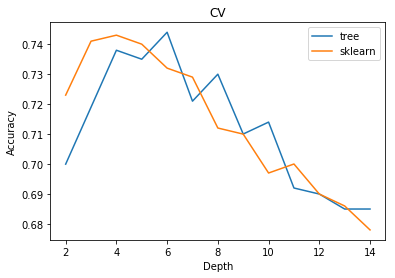

67.3790841103


In [194]:
from time import time
t0 = time()
acc_score = []
sk_score = []
for depth in range(2, 15):
    tree = DecisionTree(max_depth=depth)
    tree.fit(X, y)
    sk_tree = DecisionTreeClassifier(max_depth=depth)
    sk_tree.fit(X, y)
    acc_score.append(cross_val_score(tree, X, y, scoring='accuracy').mean())
    sk_score.append(cross_val_score(sk_tree, X, y, scoring='accuracy').mean())
DepthPlot(acc_score, sk_score, 'CV')
print(time()-t0)

20.1592741013


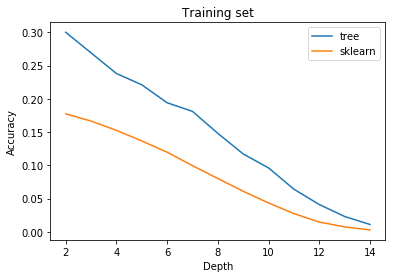

In [195]:
t0=time()
acc_score = []
sk_score = []
for depth in range(2, 15):
    tree = DecisionTree(max_depth=depth)
    tree.fit(X, y)
    sk_tree = DecisionTreeRegressor(max_depth=depth)
    sk_tree.fit(X, y)
    acc_score.append(mean_squared_error(y, tree.predict(X)))
    sk_score.append(mean_squared_error(y, sk_tree.predict(X)))
print(time() - t0)
DepthPlot(acc_score, sk_score, 'Training set')